In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import mlxtend
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix


df = pd.read_csv("C:/Users/owcha/Desktop/application_train.csv")

print('Datashape: ', df.shape)
df.head()

Datashape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
#Study of missing values.
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values_table(df)


#Rendu compte de nombreuses données manquantes entrée 28 et 44.

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


In [4]:
#Average of missing values by row.
def missing_values_by_row(df):
    total = 0
    count = 0
    for index, row in df.iterrows():
        for prop in row:
            if not prop:
                count += 1
        total += 1
        
    print( "Each row has about " + str( round(count/total) ) + " missing values." ) 
    
missing_values_by_row(df)

# => To much affected labels for deleting only columns.

Each row has about 38 missing values.


In [35]:
#Study of values type.
print( df.dtypes.value_counts() )

# => 16 labels has dtype object, it needs to be labeled. 
# Also missing values of those 16 columns has hard to transform to numerical values, using average.

float64    65
int64      41
object     16
dtype: int64


In [36]:
#Preprocessing for missing values and bad dtype.
#Missing values -> dropna, cause

df = df.dropna(axis=0)

#Bad type and useless labels.

le = LabelEncoder()
le_count = 0

useless_cat = [ col for col in df if len(list(df[col].unique())) == 1 ]
for cat in useless_cat:
    df = df.drop(cat, axis=1)

# Iterate through the columns
for col in df:
    if df[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df[col].unique())) >= 1:
            df[col] = le.fit_transform(df[col])
            le_count += 1
            
print('%d columns were label encoded.' % le_count)
print('%d columns were removed.' % len(useless_cat))

print('Datashape: ', df.shape)
print( df.dtypes.value_counts() )

16 columns were label encoded.
Datashape:  (8602, 122)
float64    65
int64      41
int32      16
dtype: int64


In [37]:
#Besoin de split notre dataset car cross validation->def de cross validation.

#Trainings dataframe.
dfTrain = df.iloc[:round(df.shape[0] * 0.9),:] 

dfRow = df.iloc[round(df.shape[0] * 0.9):,:]  
dfTest = dfRow.iloc[:(dfRow.shape[0]-5),:]
dfKeep = dfRow.iloc[(dfRow.shape[0]-5):,:]

print('dfTrain: ',dfTrain.shape)
print('dfTrain2: ',dfTrain.shape)
print('dfTest: ',dfTest.shape)
print('dfKeep: ',dfKeep.shape)

dfTrain:  (7742, 122)
dfTrain2:  (7742, 122)
dfTest:  (855, 122)
dfKeep:  (5, 122)


0    0.938646
1    0.061354
Name: TARGET, dtype: float64


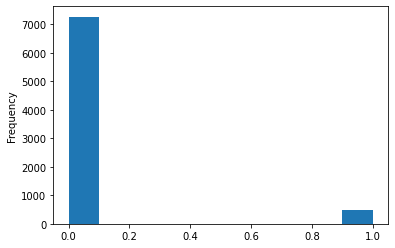

In [38]:
#Dispersion of y study.
print( pd.value_counts(dfTrain['TARGET'], normalize=True) )

dfTrain['TARGET'].astype(int).plot.hist();

Training data shape:  (14380, 122)


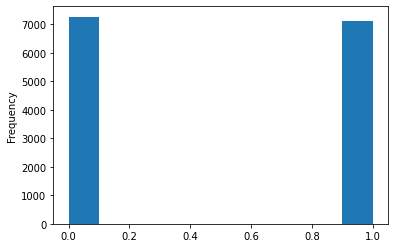

In [39]:
#Oversampling (not undersampling) because we haven't many rows.

# Separate majority and minority classes
df_majority = dfTrain[dfTrain['TARGET']==0]
df_minority = dfTrain[dfTrain['TARGET']==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=round(dfTrain.shape[0] * 0.918744),  # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
dfTrainUpsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
dfTrainUpsampled['TARGET'].value_counts()
print('Training data shape: ', dfTrainUpsampled.shape)

dfTrainUpsampled['TARGET'].astype(int).plot.hist();

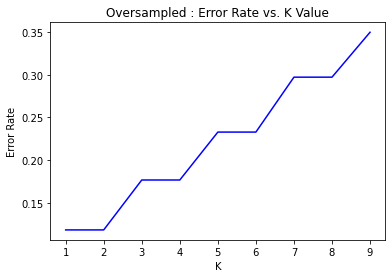

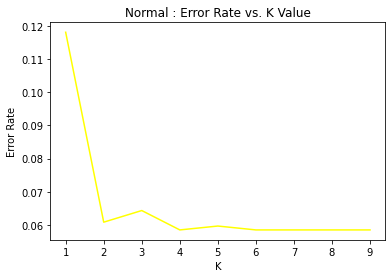

In [40]:
#Knns preparation.

#Test
X_test = dfTest.drop('TARGET', 1)
y_test = dfTest['TARGET']

#Oversampled knn.
oversampled_X_train = dfTrainUpsampled.drop('TARGET', 1)
oversampled_y_train = dfTrainUpsampled['TARGET']

#Normal knn.
X_train = dfTrain.drop('TARGET', 1)
y_train = dfTrain['TARGET']

#Find the best k for our models.

oversampled_error_rate = []
normal_error_rate = []

# Will take some time
for i in range(1,10):
    
    oversampled_knn = KNeighborsClassifier(n_neighbors=i)
    oversampled_knn.fit(oversampled_X_train, oversampled_y_train)
    pred_i = oversampled_knn.predict(X_test)
    oversampled_error_rate.append(np.mean(pred_i != y_test))
    
    normal_knn = KNeighborsClassifier(n_neighbors=i)
    normal_knn.fit(X_train, y_train)
    pred_i2 = normal_knn.predict(X_test)
    normal_error_rate.append(np.mean(pred_i2 != y_test))


plt.plot(range(1,10),oversampled_error_rate,color='blue', linestyle='solid')
plt.title('Oversampled : Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

plt.plot(range(1,10),normal_error_rate,color='yellow', linestyle='solid')
plt.title('Normal : Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

0.8818713450292398


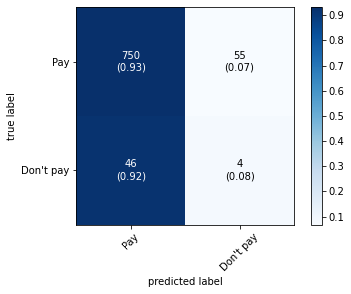

In [41]:
#Oversampled knn declaration -> with k = 2.
oversampled_knn = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
oversampled_knn.fit(oversampled_X_train, oversampled_y_train)

#Prédiction.
oversampled_pred = oversampled_knn.predict(X_test)

#Result.
conf_mat = confusion_matrix(y_test, oversampled_pred)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names=["Pay", "Don't pay"])

print ( conf_mat.diagonal().sum()/conf_mat.sum() )

0.9415204678362573


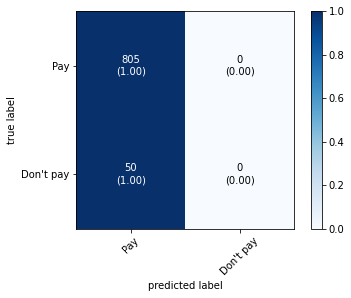

In [42]:
#Oversampled knn declaration -> with k = 4.
normal_knn = KNeighborsClassifier(n_neighbors=4, n_jobs=-1)
normal_knn.fit(X_train, y_train)

#Prédiction.
normal_pred = normal_knn.predict(X_test)

#Result.
conf_mat2 = confusion_matrix(y_test, normal_pred)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat2,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names=["Pay", "Don't pay"])

print ( conf_mat2.diagonal().sum()/conf_mat2.sum() )

In [ ]:
# TO DO -> Pourcentage pour chacun d'un point de vue interpretation.
# TO DO -> stockage des proba de chacun du test.
# TO DO -> faire un beau pickle.